In [31]:
import numpy as np
import pandas as pd
import random
import tensorflow as tf
import matplotlib.pyplot as plt
from scipy.spatial import distance_matrix
from collections import defaultdict
import time

In [3]:
def read_data():
    a = pd.read_csv('MovRankData.csv')
    movies = a.columns
    data = a.to_numpy()
    user_ids = data[:,0]
    matrix = data[:,1:]
    return list(movies)[1:], list(user_ids), np.float64(matrix)

In [4]:
movies, user_ids, data = read_data()

# Matrix completion

In [5]:
whole_mask = ~np.isnan(data)
train_split = 0.7
rand_mask = np.random.choice(a=[True, False], size=whole_mask.shape, p=[train_split, 1-train_split])
rand_mask_2 = np.random.choice(a=[True, False], size=whole_mask.shape, p=[0.5, 0.5])
train_mask = np.logical_and(whole_mask, rand_mask)
test_mask = np.logical_and(whole_mask, np.logical_and(~rand_mask, rand_mask_2))
val_mask = np.logical_and(whole_mask, np.logical_and(~rand_mask, ~rand_mask_2))

## Alternating Iteration

In [1]:
def solve_least_squares(output, inp, lam, mask):
    '''
    output m x n
    inp m x k
    mask m x n
    return val: n x k
    '''
    m1, n = output.shape
    m2, k = inp.shape
    assert m1 == m2
    weights = np.zeros((k, n))
    for i in range(n):
        #a = time.time()
        rel_output = tf.expand_dims(output[mask[:, i] , i], -1)
        rel_inp = inp[mask[:,i], :]
        #print("a", time.time()-a)
        #a = time.time()
        weights[:,[i]] = tf.linalg.lstsq(rel_inp, rel_output, l2_regularizer=lam)
        #print("b", time.time() - a)
    return weights.transpose()

In [34]:
def alternating_min(X, Y, A, lam, iters, mask):
    threshold = 1e-3
    frob_norm = []
    A = np.nan_to_num(A)
    for it in range(iters):
        a = time.time()
        Y_new = solve_least_squares(A, X, lam, mask)
        print("1", time.time() - a)
        a = time.time()
        X_new = solve_least_squares(A.transpose(), Y_new, lam, mask.transpose())
        print("2", time.time()-a)
        X, Y = X_new, Y_new
        norm = np.linalg.norm((A - np.matmul(X, Y.transpose()))*mask, ord='fro')
        frob_norm.append(norm)
        if norm <= threshold:
            break
    return X, Y, frob_norm

In [13]:
m, n = data.shape
k = 10
iters = 30
lambda_list = [10, 3, 1, 1e-1]
err_list = []
for lam in lambda_list:
    X = np.ones((m, k))
    Y = np.ones((n, k))
    X, Y, fro_norm = alternating_min(X, Y, data, lam, iters, train_mask)
    train_err = np.mean((np.nan_to_num(data - np.matmul(X, Y.transpose()))*train_mask)**2)
    test_err = np.mean((np.nan_to_num(data - np.matmul(X, Y.transpose()))*test_mask)**2)
    val_err = np.mean((np.nan_to_num(data - np.matmul(X, Y.transpose()))*val_mask)**2)
    err_list.append((train_err, test_err, val_err, fro_norm))

In [39]:
import time
alternating_min(X, Y, data, lam, iters, train_mask)


a 0.000997781753540039
b 0.006514787673950195
a 0.0011522769927978516
b 0.003561258316040039
a 0.001210927963256836
b 0.005215644836425781
a 0.0
b 0.004441738128662109
a 0.0007593631744384766
b 0.005602359771728516
a 0.0
b 0.00468134880065918
a 0.0009975433349609375
b 0.002184152603149414
a 0.0
b 0.0033843517303466797
a 0.0001938343048095703
b 0.0032532215118408203
a 0.00020456314086914062
b 0.0029947757720947266
a 0.0
b 0.001995563507080078
a 0.0
b 0.0021581649780273438
a 0.0
b 0.0035800933837890625
a 0.0
b 0.002347230911254883
a 8.225440979003906e-05
b 0.004520893096923828
a 0.0010001659393310547
b 0.0036530494689941406
a 0.0010666847229003906
b 0.004251241683959961
a 0.0010013580322265625
b 0.010904550552368164
a 0.00099945068359375
b 0.002992868423461914
a 0.0008623600006103516
b 0.008949756622314453
1 0.11330485343933105
a 0.001954793930053711
b 0.010208845138549805
a 0.001001596450805664
b 0.004063844680786133
a 0.000995635986328125
b 0.0051403045654296875
a 0.0
b 0.0052587985992

KeyboardInterrupt: 

In [16]:
for i in range(len(lambda_list)):
    print('$\lambda$ = '+str(lambda_list[i]), '&', np.round(err_list[i][0], 4), '&', np.round(err_list[i][1], 4), '&', np.round(err_list[i][2], 4), r"\\") 

$\lambda$ = 10 & 0.4812 & 0.0899 & 0.1747 \\
$\lambda$ = 3 & 0.1498 & 0.0658 & 0.1139 \\
$\lambda$ = 1 & 0.0203 & 0.0737 & 0.126 \\
$\lambda$ = 0.1 & 0.001 & 0.1761 & 0.2073 \\


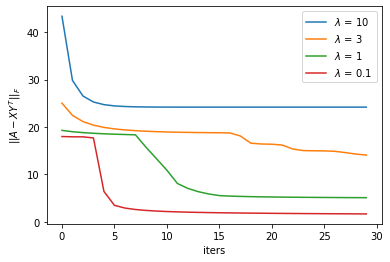

In [284]:
for i in range(len(lambda_list)):
    plt.plot(err_list[i][3], label = '$\lambda$ = '+str(lambda_list[i]))
plt.ylabel('$|| A - XY^T||_F$')
plt.xlabel('iters')
plt.legend()
plt.show()

In [161]:
'Best lambda = 3; test mse: '+str(err_list[1][0])

'Best lambda = 3; test mse: 0.11482013457798558'

In [162]:
'Time taken:' + str(12.5/4)

'Time taken:3.125'

## Nuclear Norm Trick

In [6]:
def nuclear_norm_reg_min(M, A, lam, iters, mask):
    frob_norm = []
    A = np.nan_to_num(A)
    for it in range(iters):
        M = M + mask*(A - M)
        s, u, v = tf.linalg.svd(M)
        s = tf.nn.relu(s - lam)
        M = tf.matmul(u, tf.matmul(tf.linalg.diag(s), v, adjoint_b=True))
        norm = np.linalg.norm((A - M)*mask, ord='fro')
        frob_norm.append(norm)
    return np.array(M), frob_norm

In [7]:
k = 10
iters = 30
lambda_list = [10, 3, 1, 1e-1]
err_list = []
for lam in lambda_list:
    M = np.ones(data.shape)
    M, fro_norm = nuclear_norm_reg_min(M, data, lam, iters, train_mask)
    train_err = np.mean((np.nan_to_num(data - M)*train_mask)**2)
    test_err = np.mean((np.nan_to_num(data - M)*test_mask)**2)
    val_err = np.mean((np.nan_to_num(data - M)*val_mask)**2)
    err_list.append((train_err, test_err, val_err, fro_norm))


In [15]:
import time
a = time.time()
nuclear_norm_reg_min(M, data, lam, iters, train_mask)
time.time() - a

0.053498268127441406

In [8]:
for i in range(len(lambda_list)):
    print('$\lambda$ = '+str(lambda_list[i]), '&', np.round(err_list[i][0], 4), '&', np.round(err_list[i][1], 4), '&', np.round(err_list[i][2], 4), r"\\") 

$\lambda$ = 10 & 0.4814 & 0.09 & 0.1747 \\
$\lambda$ = 3 & 0.1173 & 0.0677 & 0.1205 \\
$\lambda$ = 1 & 0.0151 & 0.1698 & 0.2472 \\
$\lambda$ = 0.1 & 0.0001 & 0.7231 & 0.9068 \\


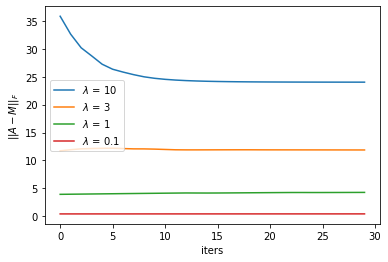

In [10]:
for i in range(len(lambda_list)):
    plt.plot(err_list[i][-1], label = '$\lambda$ = '+str(lambda_list[i]))
plt.ylabel('$|| A - M||_F$')
plt.xlabel('iters')
plt.legend()
plt.show()

In [200]:
'Best lambda = 3; test mse: '+str(err_list[1][0])

'Best lambda = 3; test mse: 0.12342806084804754'

In [201]:
'Time taken:' + str(0.1/4)

'Time taken:0.025'

# Non-negative Matrix Factorization

In [17]:
M, _ = nuclear_norm_reg_min(np.ones(data.shape), data, 3, 30, whole_mask)

## K - means clustering

In [18]:
def kmeans_cluster(M, k, iters):
    k_means = np.array(random.sample(list(M) , k))
    for it in range(iters):
        kmeans_dict = defaultdict(list)
        for i, v in enumerate(M):
            ind = np.argmin(np.sum((k_means - v)**2, -1))
            kmeans_dict[ind].append(v)
        rel_inds = [ind for ind in range(k) if len(kmeans_dict[ind])>0 ]
        k = len(rel_inds)
        k_means = np.zeros((len(rel_inds), k_means.shape[1]))
        for i in range(k):
            k_means[i] = np.mean(kmeans_dict[rel_inds[i]], axis=0)
    dist_sum = 0
    for i, v in enumerate(M):
        dist_sum += np.min(np.sum((k_means - v)**2, -1))
    return dist_sum/len(M), k_means


Text(0, 0.5, 'Average Distortions')

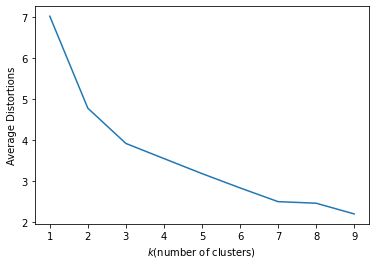

In [20]:
iters = 20
dists = []
for k in range(1,10):
    dist, _ = kmeans_cluster(M, k, iters)
    dists.append(dist)
plt.plot(range(1,10), dists)
plt.xlabel('$k$(number of clusters)')
plt.ylabel('Average Distortions')

In [21]:
dists

[7.0226592140696,
 4.778151472852359,
 3.918075217697028,
 3.549469214637571,
 3.1824327062924236,
 2.833491764792141,
 2.497864664295233,
 2.4596289869467443,
 2.198401729767704]

Using the elbow method, we can estimate $k = 3$

## Projected Gradient Descent

In [22]:
def PGD(A, W, H, iters, lr):
    frob_norm = []
    for it in range(iters):
        W = tf.nn.relu(W + lr*tf.matmul(A - tf.matmul(W, H), tf.transpose(H) ))
        H = tf.nn.relu(H + lr*tf.matmul(tf.transpose(W), A - tf.matmul(W, H) ))
        frob_norm.append(tf.norm(A - tf.matmul(W, H), ord='fro', axis=(0,1))**2 )
    return np.array(W), np.array(H), np.array(frob_norm)

In [29]:
k = 3
W = np.ones((m, k))
H = np.ones((k, n))
iters = 700
lr = 1e-2
W, H, frob_norm = PGD(M, W, H, iters, lr)

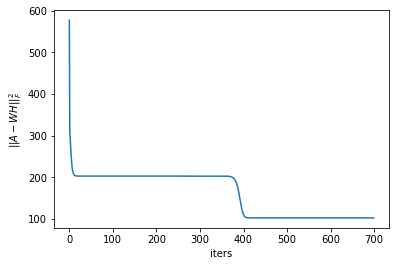

In [30]:
plt.plot(frob_norm[:])
plt.xlabel('iters')
plt.ylabel('$||A - WH ||_F^2$')
plt.show()

## Lee Seung Algorithm

In [25]:
def LeeSeung(A, W, H, iters):
    frob_norm = []
    for it in range(iters):
        W = tf.matmul(A, tf.transpose(H))*W/tf.matmul(W, tf.matmul(H, tf.transpose(H)))
        H = tf.matmul(tf.transpose(W), A)*H/tf.matmul(tf.matmul(tf.transpose(W), W), H)
        frob_norm.append(tf.norm(A - tf.matmul(W, H), ord='fro', axis=(0,1))**2 )
    return np.array(W), np.array(H), np.array(frob_norm)

In [26]:
k = 3
W = np.ones((m, k))
H = np.ones((k, n))
iters = 700
W, H, frob_norm = LeeSeung(M, W, H, iters)

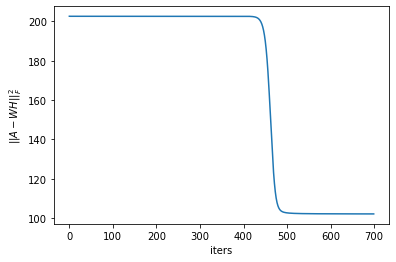

In [27]:
plt.plot(frob_norm[:])
plt.xlabel('iters')
plt.ylabel('$||A - WH ||^2_F$')
plt.show()